# Source code

## Activation

In [1]:
import numpy as np


class Activation:
    """Abstract class. Activation function used in a MLP neural network."""

    def __init__(self):
        pass

    def forward(self, A):
        """Computes forward activation function."""
        raise NotImplementedError()

    def back(self, X):
        """Computes derivative of loss function activation function w.r.t.
        activation function for a particular layer.
        """
        raise NotImplementedError()


class Sigmoid(Activation):
    """Sigmoid activation function used in a MLP neural network."""

    def __init__(self):
        pass

    def forward(self, A):
        """Computes activation of a single layer.

        Parameters
        ----------
        A : np.ndarray, shape (N, M[i])
            Input into activation func. at layer i: (Z.dot(W)+b).

        Returns
        -------
        np.ndarray, shape (N, M[i])
        """
        _Z = 1 / (1 + np.exp(-A))
        return _Z

    def back(self, _Z):
        """Computes partial derivative of loss function w.r.t. activation
        function for a particular layer.

        Parameters
        ----------
        Z : np.ndarray, shape(N, M[i])
            Output of layer i.

        Returns
        -------
        np.ndarray, shape(N, M[i])
            Partial derivative of loss function w.r.t. activation function
            at layer i.
        """
        dZ = _Z*(1-_Z)
        return dZ


class ReLU(Activation):
    """ReLU activation function used in a MLP neural network."""

    def __init__(self):
        pass

    def forward(self, A):
        """Computes activation of a single layer.

        Parameters
        ----------
        A : np.ndarray, shape (N, M[i])
            Input into activation func. at layer i: (Z.dot(W)+b).

        Returns
        -------
        np.ndarray, shape (N, M[i])
        """
        _Z = A * (A > 0)
        assert not np.any(np.isnan(_Z))
        return _Z

    def back(self, _Z):
        """Computes partial derivative of loss function w.r.t. activation
        function for a particular layer.

        Parameters
        ----------
        Z : np.ndarray, shape(N, M[i])
            Output of layer i.

        Returns
        -------
        np.ndarray, shape(N, M[i])
            Partial derivative of loss function w.r.t. activation function
            at layer i.
        """
        dZ = np.piecewise(_Z, [_Z < 0, _Z >= 0], [0, 1])
        return dZ

## Optimizer

In [2]:
import numpy as np


class Optimizer:
    """Abstract class. Strategy for updating weights and biases of MLP."""

    def __init__(self):
        pass

    def layer_update(self, mlp, i, dJdW_i, dJdb_i, grad_max):
        """Returns weight+bias updates for a single layer, i."""
        raise NotImplementedError()


class MomentumOptimizer(Optimizer):
    """Optimzier strategy that uses momentum.

    Other options are regularization and gradient-clipping.

    Parameters
    ----------
    D : int
        MLP input dimension.
    K : int
        MLP number of output classes.
    hidden_layer_sizes : array-like
        Hidden layer sizes. An array of integers.
        momentums are the same shape as the weights.
    lr : numeric
        Learning rate.
    mu : float, default 0
        Momentum parameter.
    reg : float, default 0
        Regularization parameter.
    clip_thresh : float, default np.inf
       Maximum weight/bias gradient allowed. If gradient is larger than
       clip_thresh, the gradient is replaced with clip_thresh.

    Attributes
    ----------
    vW_ : list, shape (len(M)+1)
        List of weight momentums. Same shapes as MLP's matrices in W.
    vb_ : list, shape (len(M)+1)
        List of bias momentums. Same shapes as MLP's bias vectors.
    """

    def __init__(self, D, K, hidden_layer_sizes, lr, mu=0, reg=0,
                 clip_thresh=np.inf):
        self.lr = lr
        self.mu = mu
        self.reg = reg
        self.clip_thresh = clip_thresh
        self.vW_ = [None for i in range(len(hidden_layer_sizes)+1)]
        self.vb_ = [None for i in range(len(hidden_layer_sizes)+1)]
        M = [D] + hidden_layer_sizes + [K]
        for i in range(len(hidden_layer_sizes)+1):
            self.vW_[i] = np.zeros((M[i], M[i+1]))
            self.vb_[i] = np.zeros((M[i+1]))

    def layer_update(self, mlp, i, dJdW_i, dJdb_i, grad_max):
        """Returns weight+bias updates for a single layer, i.

        Parameters
        ----------
        mlp : MLP
            MLP instance.
        i : int
            Layer index.
        dJdW_i : np.ndarray
            Weight gradients at layer i.
        dJdb_i : np.array
            Bias gradients at layer i.
        grad_max : numeric
            Current maximum gradient for any weight.

        Returns
        -------
        tuple
            np.ndarray
                Weight updates.
            np.ndarray
                Bias updates.
            float
                Max gradient of any weight (for debugging).
        """
        lr = self.lr
        reg = self.reg
        mu = self.mu
        clip_thresh = self.clip_thresh
        W_i = mlp.W[i]
        b_i = mlp.b[i]

        # Clip gradients that are too large
        dJdW_i[dJdW_i > clip_thresh] = clip_thresh
        dJdW_i[dJdW_i < -1*clip_thresh] = -1*clip_thresh
        dJdb_i[dJdb_i > clip_thresh] = clip_thresh
        dJdb_i[dJdb_i < -1*clip_thresh] = -1*clip_thresh

        # Compute max gradient update (for debugging)
        grad_max = max((grad_max, max(dJdW_i.max(), dJdW_i.min(),
                                      key=abs)))

        # Adjust gradients with regularization
        dJdW_i = dJdW_i - reg*W_i
        dJdb_i = dJdb_i - reg*b_i

        # Update momentums (velocities)
        self.vW_[i] = mu*self.vW_[i] + lr*dJdW_i
        self.vb_[i] = mu*self.vb_[i] + lr*dJdb_i

        w_update = self.vW_[i]
        b_update = self.vb_[i]

        return w_update, b_update, grad_max


class AdaGradOptimizer(Optimizer):
    """MLP optimizer that implements AdaGrad 'Adaptive Gradient'.

    AdaGrad uses a cache to keep track of how much each variable has changed,
    so that each variable changes less if it has changed a lot recently.

    On each update:
        cache = cache + gradient^2
        w = w - lr*(grad/sqrt(cache + epsilon))

    Parameters
    ----------
    D : int
        MLP input dimension.
    K : int
        MLP number of output classes.
    hidden_layer_sizes : array-like
        Hidden layer sizes. An array of integers.
        momentums are the same shape as the weights.
    lr : numeric
        Learning rate.
    epsilon : numeric, default=1e-8
        Parameter to make cache update denomenator nonzero.
    """

    def __init__(self, D, K, hidden_layer_sizes, lr, epsilon=1e-8):
        self.lr = lr
        self.epsilon = epsilon
        self.cW_ = [None for i in range(len(hidden_layer_sizes)+1)]
        self.cb_ = [None for i in range(len(hidden_layer_sizes)+1)]
        M = [D] + hidden_layer_sizes + [K]
        for i in range(len(hidden_layer_sizes)+1):
            self.cW_[i] = np.zeros((M[i], M[i+1]))
            self.cb_[i] = np.zeros((M[i+1]))

    def layer_update(self, mlp, i, dJdW_i, dJdb_i, grad_max):
        """Returns weight+bias updates for a single layer, i.

        Parameters
        ----------
        mlp : MLP
            MLP instance.
        i : int
            Layer index.
        dJdW_i : np.ndarray
            Weight gradients at layer i.
        dJdb_i : np.array
            Bias gradients at layer i.
        grad_max : numeric
            Current maximum gradient for any weight.

        Returns
        -------
        tuple
            np.ndarray
                Weight updates.
            np.ndarray
                Bias updates.
            float
                Max gradient of any weight (for debugging).
        """
        lr = self.lr
        epsilon = self.epsilon

        # Compute max gradient update (for debugging)
        grad_max = max((grad_max, max(dJdW_i.max(), dJdW_i.min(),
                                      key=abs)))

        # Update caches
        self.cW_[i] = self.cW_[i] + dJdW_i**2
        self.cb_[i] = self.cb_[i] + dJdb_i**2

        # Compute weight/biase updates using cache, eta, epsilon
        w_update = lr*(dJdW_i/np.sqrt(self.cW_[i] + epsilon))
        b_update = lr*(dJdb_i/np.sqrt(self.cb_[i] + epsilon))

        return w_update, b_update, grad_max


## MLP

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from copy import deepcopy


class MLP:
    """Multip Layer Perceptron neural network implemented with NumPy.

    Uses gradient ascent.

    Parameters
    ----------
    D : int
        Input dimension.
    K : int
        Number of output classes.
    hidden_layer_sizes : array-like
        Hidden layer sizes. An array of integers.
    Z : Activation
        Activation function.
    optimizer : Optimizer
        Optimizer.

    Attributes
    ----------
    n_layers, int
        Number of hidden layers, defined by length of hidden_layer_sizes.
    M : list, length (n_layers+2)
        Hidden layer sizes, with M[0] set to D and M[-1] set to K. This makes
        computing recursive forward and back propagation easier.
    W : list, shape (len(M)+1)
        List of weight matrices.
    b : list, shape (len(M)+1)
        List of bias vectors.

    Examples
    --------
    >>> D = X_train.shape[1]
    >>> K = Y_train.shape[0]
    >>> hidden_layer_sizes = [5, 5]
    >>> Z = Sigmoid()
    >>> opt = MomentumOptimizer(hidden_layer_sizes, lr=.001, mu=.5)
    >>> model = MLP(D, hidden_layer_sizes, K, Z, opt)
    >>> model.fit(X_train, Y_train)
    >>> preds, _ = model.forward(X_test)
    """

    def __init__(self, D, K, hidden_layer_sizes, Z, optimizer):
        self.D = D
        self.K = K
        self.Z = Z
        self.optimizer = optimizer
        self.n_layers_ = len(hidden_layer_sizes)
        self.M = [D] + hidden_layer_sizes + [K]
        n_layers = self.n_layers_
        M = self.M
        self.W = [None for i in range(n_layers+1)]
        self.b = [None for i in range(n_layers+1)]

        # Randomly initialize weights
        # Normalize with 1/sqrt(D)
        norm = 1/np.sqrt(D)
        for i in range(n_layers+1):
            self.W[i] = norm*np.random.randn(M[i], M[i+1])
            self.b[i] = norm*np.random.randn(M[i+1])

    def __copy__(self):
        """Returns a copy of self.

        Returns
        -------
        MLP
            Copy of self.
        """
        obj = type(self).__new__(self.__class__)
        obj.__dict__.update(self.__dict__.copy())
        return obj

    def __deepcopy__(self, memo):
        """Returns a deep copy of self.

        Useful in DQNs when copying the main network to the target network.

        Parameters
        ----------
        memo : dict
            Object's memo dict.

        Returns
        -------
        MLP
            Copy of self.
        """
        obj = type(self).__new__(self.__class__)
        obj.__dict__.update(self.__dict__.copy())
        self.W = deepcopy(self.W, memo)
        self.b = deepcopy(self.b, memo)
        return obj

    def forward(self, X):
        """Runs one forward pass through all layers.

        Final layer inputs are normalized prior to passing through softmax.

        Parameters
        ----------
        X : np.ndarray, shape (N, D)
            Input matrix.

        Returns
        -------
        Y : np.ndarray, shape(N, K)
            Outputs as indicator matrix.
        Z : list, shape (n_layers+1)
            Z values indexed by layer. Used for backpropagation. Note that Z[0]
            is X and Z[-1] is Y.
        """
        n_layers = self.n_layers_
        W = self.W
        b = self.b

        # Collect Z at each layer so we can use them in backprop.
        Z = [None for i in range(n_layers+2)]
        Z[0] = X.copy()

        for i in range(1, self.n_layers_+1):
            Z[i] = self._forward_single_layer(Z[i-1], i)
            assert not np.any(np.isnan(Z[i]))

        final_A = Z[-2].dot(W[n_layers]) + b[n_layers]
        assert not np.any(np.isnan(final_A))

        # Compute final layer outputs
        Y = self._forward_final_layer(final_A)

        Z[-1] = Y
        assert len(Z) == n_layers + 2
        assert not np.any(np.isnan(Z[-1]))

        return Y, Z

    def fit(self, X, Y, epochs=1000, batch_size=1000):
        """Fits the neural network using backpropagation.

        Parameters
        ----------
        X : numpy.ndarray, shape (N, D)
            Input matrix.
        Y : array-like, shape (N,)
            Vector of targets. This will be transformed into a onehot encoded
            indicator matrix, called T.
        batch_size : int, default=1000
            Training batch size. If batch_size > len(X), then the batch size
            will be changed to len(X).
        epochs : int
            Number of epochs.

        Returns
        -------
        None
        """
        T = self._transform_targets(Y)

        if batch_size > len(X):
            print('WARNING: Batch size > len(X). Setting batch size to len(X)')
            batch_size = len(X)
        n_batches = int(len(X) / batch_size)
        losses = []
        performance_metrics = []

        for epoch in range(epochs):
            Output = np.empty_like(T)  # Aggregate Output for entire epoch
            grad_max = 0  # For debugging

            for b in range(n_batches):
                # Select batch
                lower_idx = b*batch_size
                upper_idx = (b+1)*batch_size
                if upper_idx > len(X):
                    upper_idx = len(X) - 1
                X_batch = X[lower_idx:upper_idx, :]

                # Predict output for batch
                Output_batch, Z_batch = self.forward(X_batch)
                Output[lower_idx:upper_idx] = Output_batch

                # Update weights and biases at each layer
                T_batch = T[lower_idx:upper_idx]
                _grad_max = self.update(T_batch, Output_batch, Z_batch)
                grad_max = max([grad_max, _grad_max])

            if epoch % (epochs / 10) == 0:
                loss = self._loss(T, Output)
                P = self._transform_output(Output)
                pm = self._performance_metric(Y, P)
                out = 'epoch: {}'.format(epoch)
                out += ', loss: {:.2f}'.format(loss)
                out += ', performance_metric: {:.4f}'.format(pm)
                w_max = max([w.max() for w in self.W])
                out += ', max weight: {:.3f}'.format(w_max)
                out += ', max weight gradient: {}'.format(grad_max)
                print(out)
                losses.append(loss)
                performance_metrics.append(pm)

        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(13, 5))
        ax0.plot(losses[1:])
        ax0.set_title('Loss')
        ax1.plot(performance_metrics[1:])
        ax1.set_title('Performance Metric')
        plt.show()

        return None

    def predict(self, X):
        """Wrapper method around forward() and _transform_output.

        This method allows MLPs to conform to scikit-learn's fit/predict
        schema.

        Parameters
        ----------
        X : np.ndarray, shape (N, D)
            Input matrix.

        Returns
        -------
        ?
            Whatever `transformed_output()` returns.
        """
        Output, Z = self.forward(X)
        transformed_Output = self._transform_output(Output)
        return transformed_Output

    def update(self, T, Output, _Z):
        """Performs one backprop update, updating weights and biases for each
        layer.

        Parameters
        ----------
        T : np.ndarray, shape (K,)
            Targets
        Output : np.ndarray, shape (K,)
            Predictions
        _Z : list<np.ndarray>, shape (n_layer+1)
            Outputs at each layer
        Returns
        -------
        numeric
            Max gradient update (for debugging during training).
        """
        opt = self.optimizer
        n_layers = self.n_layers_

        # For each layer, iterating backwards from final layer, compute
        # deltas, weight partials, and update weights/biases.
        Delta = [None for i in range(n_layers+1)]
        grad_max = 0
        for i in range(n_layers, -1, -1):
            if i == n_layers:
                # Compute delta at final layer
                Delta[i] = self._backprop_delta_final_layer(T, Output)
            else:
                # Compute deltas at middle layer
                Delta[i] = self._backprop_delta(Delta[i+1], self.W[i+1],
                                                _Z[i+1], i)

            # Compute weight and bias partial gradients
            dJdW_i = self._dJdW(_Z[i], Delta[i], i)
            dJdb_i = self._dJdb(Delta[i], i)

            w_update, b_update, grad_max = opt.layer_update(self, i, dJdW_i,
                                                            dJdb_i, grad_max)

            # Update weights
            self.W[i] -= w_update
            self.b[i] -= b_update

        return grad_max

    def _forward_single_layer(self, prev_Z, i):
        """Runs one forward pass through a single layer.

        Parameters
        ----------
        prev_Z : numpy.ndarray, shape(N, M[i-1])
            Output of layer i-1.
        i : int
            Index of layer.

        Returns
        -------
        tuple
            Y : np.ndarray, shape (N, M[i])
                Output of layer i.
        """
        N = len(prev_Z)
        M = self.M
        W = self.W
        b = self.b
        Z = self.Z
        assert prev_Z.shape == (N, M[i-1])
        A = prev_Z.dot(W[i-1]) + b[i-1]
        assert A.shape == (N, M[i])
        _Z = Z.forward(A)
        assert _Z.shape == (N, M[i])
        assert not np.any(np.isnan(_Z))
        return _Z

    def _forward_final_layer(self, final_A):
        """Abstract method. Computes the forward pass of the final layer.

        This is different between classification and regression.

        Parameters
        ----------
        final_A, np.ndarray, shape (N, K)
            Final layer Wz+b

        Returns
        -------
        np.ndarray, shape (N, K)
            Final layer outputs.
        """
        raise NotImplementedError()

    def _transform_output(self, Output):
        """Abstract method. Transforms final layer output into predictions.

        Parameters
        ----------
        np.ndarray, shape (N, K)

        Returns
        -------
        ?
            Implementation-specific
        """
        raise NotImplementedError()

    def _transform_targets(self, Y):
        """Abstract method. Transforms targets.

        Differs b/w regression and classification.

        Parameters
        ----------
        Y : array-like, shape(N)

        Returns
        -------
        ?
            Transformed targets. Implementation is specific to MLP type.
        """
        raise NotImplementedError()

    def _to_indicator_matrix(self, x, n_distinct):
        """Turns a vector of integers into an indicator matrix.

        Parameters
        ----------
        x : array-like
            Vector of integers.
        n_distinct_values, int
            The number of distinct integers in the vector.

        Returns
        -------
        numpy.ndarray, shape (len(x), n_distinct)
            Indicator matrix
        """
        n = len(x)
        X = np.zeros((n, n_distinct))
        for i in range(n):
            X[i, x[i]] = 1
        return X

    def _loss(self, T, Y):
        """
        Abstract method. Computes the loss of the predictions.

        Parameters
        ----------
        T : np.ndarray, shape(N, K)
            Targets as indicator matrix.
        Y : np.ndarray, shape(N, K)
            Predictions as indicator matrix.

        Returns
        -------
        float
            Total loss.
        """
        raise NotImplementedError()

    def _performance_metric(self, Y, P):
        """Abstract method. Computes performance metric.

        Parameters
        ----------
        Y : array-like, shape (N,)
            Targets.
        P : array-like, shape (N,)
            Predictions.

        Returns
        -------
        float
            ?
        """
        raise NotImplementedError()

    def _backprop_delta_final_layer(self, T, Output):
        """Abstract method.

        Compute the backprop delta for the final layer. This is different for
        regression and classification, since classification uses softmax.

        Parameters
        ----------
        T : np.ndarray, shape (N[lower_idx:upper_idx], K)
            Batch targets as indicator matrix.
        Output : np.ndarray, shape (N[lower_idx:upper_idx], K)
            Batch output.

        Returns
        -------
        np.ndarray, shape (N, K)
            Delta of final layer.
        """
        raise NotImplementedError()

    def _backprop_delta(self, subs_Delta, subs_W, _Z, i):
        """Computes the delta for computing weight update.

        Parameters
        ----------
        subs_Delta : np.ndarray, shape (N, M[i+2])
            Delta at subsequent layer (i+1).
        subs_W : np.ndarray, shape (M[i+1], M[i+2])
            Weights at subsequent layer (i+1).
        _Z : np.ndarray, shape (N, M[i+1])
            Layer outputs at current layer. Note that _Z[i] comes BEFORE W[i],
            since we set _Z[0] to X. Therefore, the Z index for the ith layer
            is Z[i+1].
        i : int
            Index of hidden layer.

        Returns
        -------
        np.ndarray, shape (N, M[i+1])
            Delta of layer i.
        """
        M = self.M
        N = len(_Z)
        Z = self.Z
        assert subs_Delta.shape == (N, M[i+2])
        assert subs_W.shape == (M[i+1], M[i+2])
        assert _Z.shape == (N, M[i+1])
        dJdZ = Z.back(_Z)
        ret = (subs_Delta.dot(subs_W.T))*dJdZ
        assert ret.shape == (N, M[i+1])
        return ret

    def _dJdW(self, prev_Z, Delta, i):
        """Computes partial derivative of loss function w.r.t. weights at layer i.

        Parameters
        ----------
        prev_Z : np.ndarray, shape (N, M[i])
            Output of previous layer.
        Delta : np.ndarray, shape(N, M[i+1])
            Delta of current layer.
        i : int
            Hidden layer index.

        Returns
        -------
        np.ndarray, shape(M[i], M[i+1])
            Partial derivatives of loss function w.r.t. weights at layer i.
        """
        M = self.M
        N = len(prev_Z)
        assert prev_Z.shape == (N, M[i])
        assert Delta.shape == (N, M[i+1])
        ret = prev_Z.T.dot(Delta)
        assert ret.shape == (M[i], M[i+1])
        return ret

    def _dJdb(self, Delta, i):
        """
        Computes partial derivative of loss function w.r.t. biases at layer i.

        Parameters
        ----------
        Delta : np.ndarray, shape(N, M[i+1])
            Delta of current layer.
        i : int
            Hidden layer index.

        Returns
        -------
        np.ndarray, shape(M[i+1])
            Partial derivatives of loss function w.r.t. biases at layer i.
        """
        M = self.M
        N = Delta.shape[0]
        assert Delta.shape == (N, M[i+1])
        ret = np.sum(Delta, axis=0)
        assert ret.shape == (M[i+1],)
        return ret


class MLPClassifier(MLP):

    def _transform_targets(self, Y):
        """Transforms targets into indicator matrix.

        Parameters
        ----------
        Y : array-like, shape(N)

        Returns
        -------
        np.ndarray, shape(N, K)
            Transformed targets as indicator matrix.
        """
        K = self.K
        return self._to_indicator_matrix(Y, K)

    def _forward_final_layer(self, final_A):
        """Computes the forward pass of the final layer.

        For classificaiton, this normalizes the inputs and computes softmax.

        Parameters
        ----------
        final_A, np.ndarray, shape (N, K)
            Final layer Wz+b

        Returns
        -------
        np.ndarray, shape (N, K)
            Final layer outputs.
        """
        K = self.K
        N = final_A.shape[0]

        # Normalize inputs
        final_A_mean = np.stack((final_A.mean(axis=1),) * K, axis=-1)
        final_A_std = np.stack((final_A.std(axis=1),) * K, axis=-1)
        final_A = (final_A - final_A_mean) / final_A_std

        # Compute softmax
        expA = np.exp(final_A)
        assert not np.any(np.isnan(expA))
        Y = expA / expA.sum(axis=1, keepdims=True)
        assert Y.shape == (N, K)
        assert not np.any(np.isnan(Y))

        return Y

    def _transform_output(self, Output):
        """Transforms final layer output into predictions, which are an array
        of predicted classes.

        Parameters
        ----------
        np.ndarray, shape (N, K)

        Returns
        -------
        np.ndarray, shape (N,)
            Array of predicted classes.
        """
        P = np.argmax(Output, axis=1)
        return P

    def _loss(self, T, Y):
        """Computes the loss of the predictions using T*log(Y).

        Parameters
        ----------
        T : np.ndarray, shape(N, K)
            Targets as indicator matrix.
        Y : np.ndarray, shape(N, K)
            Predictions as indicator matrix.

        Returns
        -------
        float
            Total cost (error).
        """
        loss = -T*np.log(Y)
        loss = loss.sum()
        assert not np.any(np.isnan(loss))
        return loss

    def _performance_metric(self, Y, P):
        """Determines the classification rate, n_correct / n_total.

        Parameters
        ----------
        Y : array-like, shape (N,)
            Targets.
        P : array-like, shape (N,)
            Predictions.

        Returns
        -------
        float
            n_correct / n_total
        """
        assert np.shape(Y) == np.shape(P)
        n_correct = 0
        n_total = 0
        for i in range(len(Y)):
            n_total += 1
            if Y[i] == P[i]:
                n_correct += 1
        return float(n_correct) / n_total

    def _backprop_delta_final_layer(self, T, Output):
        """Compute the backprop delta for the final layer.

        For classification, this factors in the softmax derivative.

        Parameters
        ----------
        T : np.ndarray, shape (N[lower_idx:upper_idx], K)
            Batch targets as indicator matrix.
        Output : np.ndarray, shape (N[lower_idx:upper_idx], K)
            Batch output.

        Returns
        -------
        np.ndarray, shape (N, K)
            Delta of final layer.
        """
        return -1*(T - Output)


class MLPRegressor(MLP):

    def _transform_targets(self, Y):
        """Returns targets as is.

        Parameters
        ----------
        Y : array-like, shape(N)

        Returns
        -------
        array-like, shape (N)
            Targets as is.
        """
        return Y

    def _forward_final_layer(self, final_A):
        """Computes the forward pass of the final layer.

        For regression, this is just the final Wz+b.

        Parameters
        ----------
        final_A, np.ndarray, shape (N, K)
            Final layer Wz+b

        Returns
        -------
        np.ndarray, shape (N, K)
            Final layer outputs.
        """
        return final_A

    def _transform_output(self, Output):
        """Returns Output as is.

        Parameters
        ----------
        np.ndarray, shape (N, K)

        Returns
        -------
        np.array, shape (N,)
            Array of Outputs.
        """
        return Output

    def _loss(self, T, Y):
        """Computes the loss of the predictions using MSE.

        Note that this is actually the reward since we're doing gradient
        ascent.

        Parameters
        ----------
        T : np.ndarray, shape(N, K)
            Targets as indicator matrix.
        Y : np.ndarray, shape(N, K)
            Predictions as indicator matrix.

        Returns
        -------
        float
            Total loss.
        """
        loss = .5*((T-Y)**2).mean()
        assert not np.any(np.isnan(loss))
        return loss

    def _performance_metric(self, Y, P):
        """Computes r2.

        Parameters
        ----------
        Y : array-like, shape (N,)
            Targets.
        P : array-like, shape (N,)
            Predictions.

        Returns
        -------
        float
            r2
        """
        return r2_score(Y, P)

    def _backprop_delta_final_layer(self, T, Output):
        """Compute the backprop delta for the final layer. For regression, this
        is just dJ/dY, where J is MSE, or `.5*((T-Y)**2).mean()`.

        Parameters
        ----------
        T : np.ndarray, shape (N[lower_idx:upper_idx], K)
            Batch targets as indicator matrix.
        Output : np.ndarray, shape (N[lower_idx:upper_idx], K)
            Batch output.

        Returns
        -------
        np.ndarray, shape (N, K)
            Delta of final layer.
        """
        return -1*(T-Output)

# Classification - Overlapping clouds

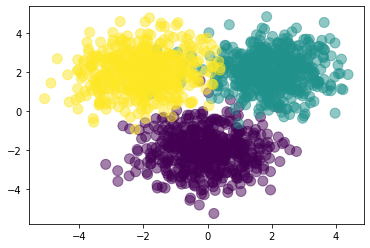

epoch: 0, loss: 2643.25, performance_metric: 0.3700, max weight: 1.772, max weight gradient: 245.7843556461986
epoch: 50, loss: 1246.25, performance_metric: 0.6167, max weight: 1.850, max weight gradient: 145.65591166670185
epoch: 100, loss: 714.81, performance_metric: 0.8467, max weight: 1.910, max weight gradient: 91.38462987486704
epoch: 150, loss: 603.03, performance_metric: 0.9080, max weight: 1.947, max weight gradient: 81.19463199665725
epoch: 200, loss: 556.67, performance_metric: 0.9333, max weight: 1.978, max weight gradient: 77.19562561900035
epoch: 250, loss: 533.80, performance_metric: 0.9493, max weight: 2.006, max weight gradient: 75.95966333818603
epoch: 300, loss: 519.80, performance_metric: 0.9560, max weight: 2.032, max weight gradient: 76.06876370424794
epoch: 350, loss: 509.98, performance_metric: 0.9607, max weight: 2.056, max weight gradient: 76.94772418169322
epoch: 400, loss: 502.86, performance_metric: 0.9640, max weight: 2.079, max weight gradient: 78.5486398

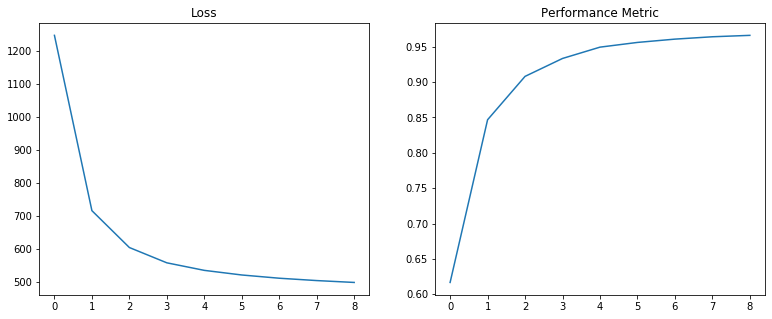

In [6]:
import numpy as np
import matplotlib.pyplot as plt


def create_data(Nclass, D, M, K):
    X1 = np.random.randn(Nclass, D) + np.array([0, -2])
    X2 = np.random.randn(Nclass, D) + np.array([2, 2])
    X3 = np.random.randn(Nclass, D) + np.array([-2, 2])
    X = np.vstack([X1, X2, X3])

    Y = np.array([0]*Nclass + [1]*Nclass + [2]*Nclass)

    # let's see what it looks like
    plt.scatter(X[:,0], X[:,1], c=Y, s=100, alpha=0.5)
    plt.show()
    
    return X, Y

np.random.seed(123)

Nclass = 500
D = 2 # dimensionality of input
M = [10] # hidden layer sizes
K = 3 # number of classes

X, Y = create_data(Nclass, D, M, K)

# opt = MomentumOptimizer(D, K, M, lr=1e-7, mu=.95)
opt = AdaGradOptimizer(D, K, M, lr=.005)

mlp = MLPClassifier(D, K, M, ReLU(), opt)

mlp.fit(X, Y, 500, batch_size=100)

preds = mlp.predict(X)

# Classification - MNIST

In [21]:
import pandas as pd


mnist_train = pd.read_csv('./data/mnist-in-csv/mnist_train.csv')
mnist_test = pd.read_csv('./data/mnist-in-csv/mnist_test.csv')

X_train = mnist_train.loc[:, mnist_train.columns != 'label'].values
y_train = mnist_train['label'].values

X_test = mnist_test.loc[:, mnist_test.columns != 'label'].values
y_test = mnist_test['label'].values

epoch: 0, loss: 110604.70, performance_metric: 0.4094, max weight: 0.165, max weight gradient: 210.98771749977539
epoch: 1, loss: 67747.91, performance_metric: 0.7190, max weight: 0.165, max weight gradient: 32.30383318945917
epoch: 2, loss: 60616.13, performance_metric: 0.7853, max weight: 0.165, max weight gradient: 22.617942910793865
epoch: 3, loss: 58355.42, performance_metric: 0.8096, max weight: 0.165, max weight gradient: 21.62461708185397
epoch: 4, loss: 57591.34, performance_metric: 0.8213, max weight: 0.166, max weight gradient: 18.736335681596227


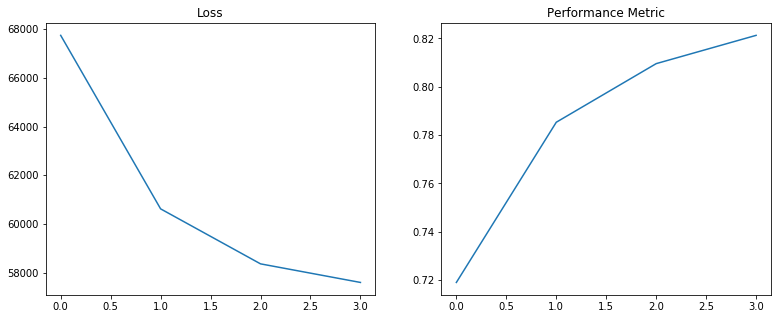

Test accuracy: 0.825


In [22]:
np.random.seed(123)


D = 784
K=10
hidden_layer_sizes = [800, 200]

Z = Sigmoid()
opt = MomentumOptimizer(D, K, hidden_layer_sizes, lr=1e-5, mu=.7, clip_thresh=50000)

model = MLPClassifier(D, K, hidden_layer_sizes,
                      Z=Z, optimizer=opt)

model.fit(X_train, y_train, epochs=5)
preds = model.predict(X_test)

test_acc = len(np.where(preds == y_test)[0])/len(y_test)
print('Test accuracy: {:.3f}'.format(test_acc))

# Classification - Iris Setosa

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split


iris = pd.read_csv('./data/iris-setosa.csv')
iris['species'] = pd.Categorical(iris.species)
iris['target'] = iris['species'].cat.codes
iris_train, iris_test = train_test_split(iris, test_size=.33)
X_train = iris_train[['sepal_length', 'sepal_width',
                      'petal_length', 'petal_width']].values
y_train = iris_train['target'].values
X_test = iris_test[['sepal_length', 'sepal_width',
                    'petal_length', 'petal_width']].values
y_test = iris_test['target'].values

epoch: 0, loss: 159.52, performance_metric: 0.3100, max weight: 1.196, max weight gradient: 47.2662577712663
epoch: 1500, loss: 90.90, performance_metric: 0.4900, max weight: 1.196, max weight gradient: 0
epoch: 3000, loss: 61.56, performance_metric: 0.7000, max weight: 1.196, max weight gradient: 6.5624709363698095
epoch: 4500, loss: 52.07, performance_metric: 0.9100, max weight: 1.196, max weight gradient: 4.5080457399229985
epoch: 6000, loss: 48.41, performance_metric: 0.9600, max weight: 1.196, max weight gradient: 4.138165364149556
epoch: 7500, loss: 46.62, performance_metric: 0.9800, max weight: 1.196, max weight gradient: 3.920748320868749
epoch: 9000, loss: 45.66, performance_metric: 0.9700, max weight: 1.195, max weight gradient: 3.7966289668186404
epoch: 10500, loss: 45.15, performance_metric: 0.9700, max weight: 1.195, max weight gradient: 3.7773875221904056
epoch: 12000, loss: 44.89, performance_metric: 0.9600, max weight: 1.205, max weight gradient: 4.360154188077871
epoch

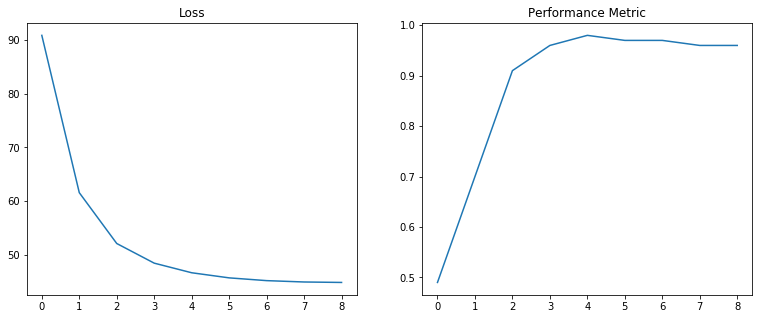

Test accuracy: 0.400


In [11]:
np.random.seed(123)

opt = MomentumOptimizer(D=4, K=3, hidden_layer_sizes=[25], lr=5e-6, mu=0, reg=0)

model = MLPClassifier(D=4, hidden_layer_sizes=[25], K=3, Z=Sigmoid(),
                      optimizer=opt)

model.fit(X_train, y_train, 15000)

preds = model.predict(X_test)
digit_preds = np.argmax(preds)
test_acc = len(np.where(digit_preds == y_test)[0])/len(y_test)
print('Test accuracy: {:.3f}'.format(test_acc))

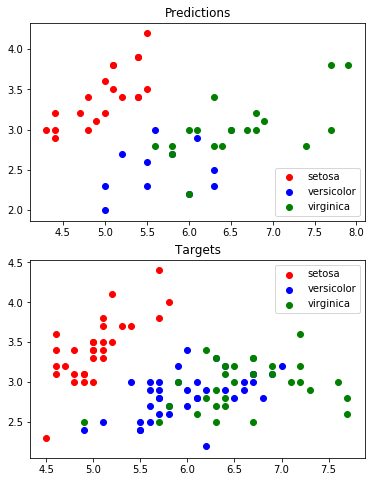

In [12]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(6,8))

iris_test0 = iris_test.query('target == 0')
iris_test1 = iris_test.query('target == 1')
iris_test2 = iris_test.query('target == 2')

ax0.scatter(iris_test0['sepal_length'], iris_test0['sepal_width'], label='setosa', c='r')
ax0.scatter(iris_test1['sepal_length'], iris_test1['sepal_width'], label='versicolor', c='b')
ax0.scatter(iris_test2['sepal_length'], iris_test2['sepal_width'], label='virginica', c='g')
ax0.set_title('Predictions')
ax0.legend()

iris_train0 = iris_train.query('target == 0')
iris_train1 = iris_train.query('target == 1')
iris_train2 = iris_train.query('target == 2')

ax1.set_title('Targets')
ax1.scatter(iris_train0['sepal_length'], iris_train0['sepal_width'], label='setosa', c='r')
ax1.scatter(iris_train1['sepal_length'], iris_train1['sepal_width'], label='versicolor', c='b')
ax1.scatter(iris_train2['sepal_length'], iris_train2['sepal_width'], label='virginica', c='g')
ax1.legend()

# Classification - Spiral

## Source code for plotting predictions during training

In [227]:
import numpy as np
import matplotlib.pyplot as plt

        
class SpiralMLP(MLPClassifier):

    def fit(self, X, Y, epochs=50000, batch_size=100):
        """
        Fits the neural network using backpropagation.

        Parameters
        ----------
        X : numpy.ndarray, shape (N, D)
            Input matrix.
        Y : array-like, shape (N,)
            Vector of targets. This will be transformed into a onehot encoded
            indicator matrix, called T.
        batch_size : int, default=1000
            Training batch size. If batch_size > len(X), then the batch size will be changed to len(X).
        epochs : int
            Number of epochs.

        Returns
        -------
        None
        """
        n_layers = self.n_layers_
        K = self.K
        learning_rate = self.learning_rate
        reg = self.reg

        T = self._transform_targets(Y)

        if batch_size > len(X):
            print('WARNING: Batch size > len(X). Setting batch size to len(X)')
            batch_size = len(X)
        n_batches = int(len(X) / batch_size) + 1
        losses = []
        performance_metrics = []
        
        for epoch in range(epochs):
            _Output = np.zeros_like(T)  #  Aggregate Output for entire epoch
            
            for b in range(n_batches):
                lower_idx = b*batch_size
                upper_idx = (b+1)*batch_size
                if upper_idx > len(X):
                    upper_idx = len(X)
                X_batch = X[lower_idx:upper_idx, :]
                Output, _Z = self.forward(X_batch)
                _Output[lower_idx:upper_idx] = Output
                
                # this is gradient ASCENT, not DESCENT
                Delta = [None for i in range(n_layers+1)]
                for i in range(n_layers, -1, -1):  # Iterate backwards
                    W = self.W
                    b = self.b

                    if i == n_layers:
                        Delta[i] = self._backprop_delta_final_layer(T[lower_idx:upper_idx, :], Output)
                    else:
                        Delta[i] = self._backprop_delta(Delta[i+1], W[i+1], _Z[i+1],
                                                        i)

                    dJdW_i = self._dJdW(_Z[i], Delta[i], i)
                    dJdb_i = self._dJdb(Delta[i], i)

                    W[i] -= learning_rate * dJdW_i + reg*W[i]
                    b[i] -= learning_rate * dJdb_i + reg*b[i]

                    self.W = W
                    self.b = b
            if epoch % (epochs / 5) == 0:
                l = self._loss(T, _Output)
                P = np.argmax(_Output, axis=1)
                pm = self._performance_metric(Y, P)
                print("epoch:", epoch, "loss:", l, "performance_metric:", pm)
                losses.append(l)
                performance_metrics.append(pm)
                # Plot predictions
                digit_preds = np.argmax(_Output, axis=1)
                t1_idx = np.where(Y == 0)
                t2_idx = np.where(Y == 1)
                t3_idx = np.where(Y == 2)
                p1_idx = np.where(digit_preds == 0)
                p2_idx = np.where(digit_preds == 1)
                p3_idx = np.where(digit_preds == 2)
                t1 = X[t1_idx]
                t2 = X[t2_idx]
                t3 = X[t3_idx]
                p1 = X[p1_idx]
                p2 = X[p2_idx]
                p3 = X[p3_idx]
                fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
                ax0.scatter(t1[:, 0], t1[:, 1], c='r', label='0')
                ax0.scatter(t2[:, 0], t2[:, 1], c='b', label='1')
                ax0.scatter(t3[:, 0], t3[:, 1], c='g', label='2')
                ax1.scatter(p1[:, 0], p1[:, 1], c='r', label='0')
                ax1.scatter(p2[:, 0], p2[:, 1], c='b', label='1')
                ax1.scatter(p3[:, 0], p3[:, 1], c='g', label='2')
                ax0.set_title('Targets')
                ax1.set_title('Predictions')
                ax1.legend()
                plt.show(block=False)

        for i, loss in enumerate(losses):
            print("epoch:", (i+1)*(epochs/5),
                  "cost:", loss,
                  "performance_metric:", performance_metrics[i])
            
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        ax.plot(losses[1:])
        ax.set_title('Loss')
        plt.show()

        return None

## Train

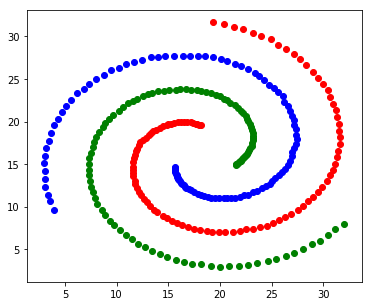

In [193]:
spiral = pd.read_csv('./data/spiral.csv')

fig, ax = plt.subplots(1, 1, figsize=(6,5))

s1 = spiral.query('target == 1')
s2 = spiral.query('target == 2')
s3 = spiral.query('target == 3')

ax.scatter(s1.x, s1.y, c='r')
ax.scatter(s2.x, s2.y, c='b')
ax.scatter(s3.x, s3.y, c='g')


from sklearn.model_selection import train_test_split

spiral = pd.read_csv('./data/spiral.csv')
# Targets are indexed starting at 1, which messes up to_indicator_matrix
spiral['target'] = spiral['target'] - 1


# Normalize values (otherwise )
spiral['x_norm'] = (spiral['x'] - spiral['x'].mean()) / spiral['x'].std()
spiral['y_norm'] = (spiral['y'] - spiral['y'].mean()) / spiral['y'].std()

spiral_train, spiral_test = train_test_split(spiral, test_size=.33)
X_train = spiral_train[['x_norm', 'y_norm']].values
y_train = spiral_train['target'].values
X_test = spiral_test[['x_norm', 'y_norm']].values
y_test = spiral_test['target'].values

epoch: 0 loss: 312.3220723795083 performance_metric: 0.3014354066985646


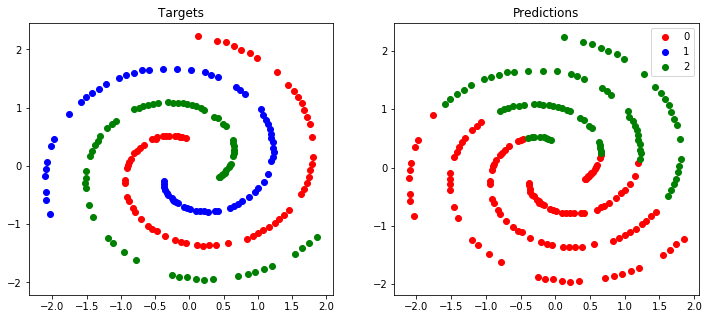

epoch: 200 loss: 318.03888454781224 performance_metric: 0.3444976076555024


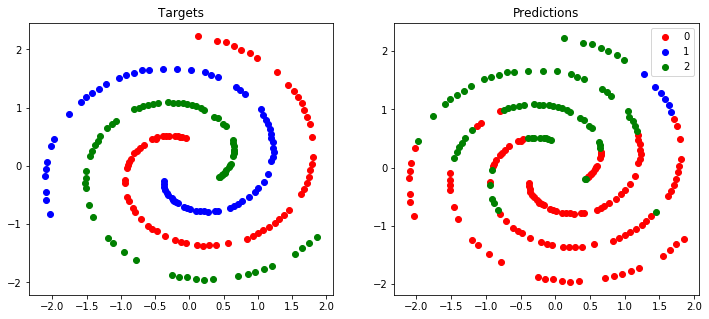

epoch: 400 loss: 279.0885957082136 performance_metric: 0.4019138755980861


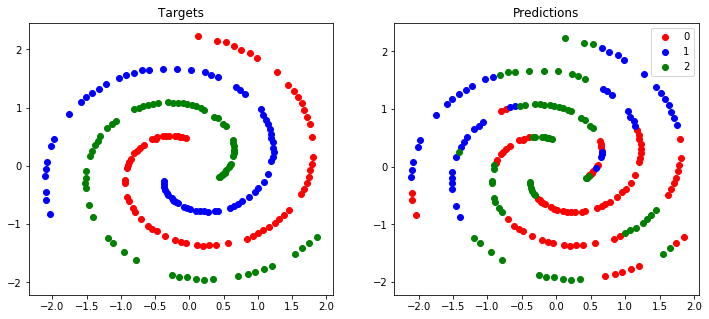

epoch: 600 loss: 272.8813577514776 performance_metric: 0.3923444976076555


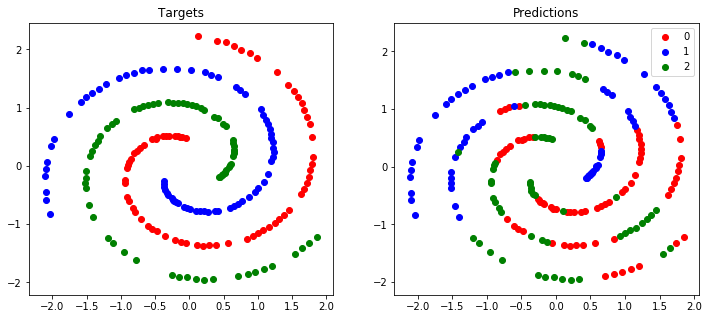

epoch: 800 loss: 240.3828822745495 performance_metric: 0.4688995215311005


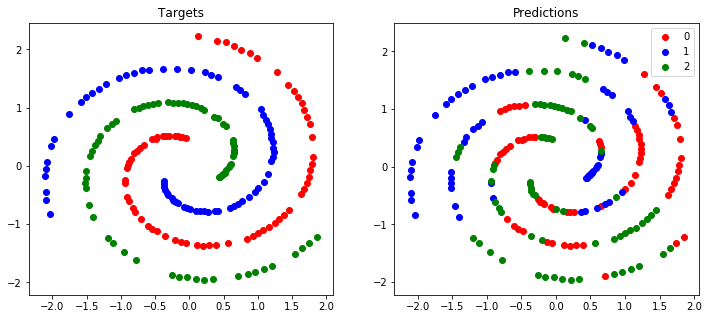

epoch: 200.0 cost: 312.3220723795083 performance_metric: 0.3014354066985646
epoch: 400.0 cost: 318.03888454781224 performance_metric: 0.3444976076555024
epoch: 600.0 cost: 279.0885957082136 performance_metric: 0.4019138755980861
epoch: 800.0 cost: 272.8813577514776 performance_metric: 0.3923444976076555
epoch: 1000.0 cost: 240.3828822745495 performance_metric: 0.4688995215311005


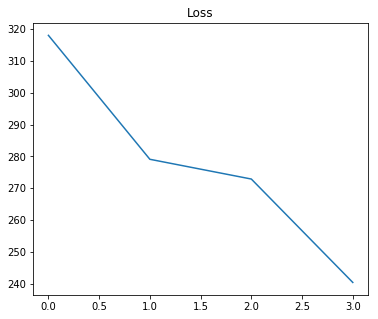

Test accuracy: 0.583


In [228]:
np.random.seed(123)

model = SpiralMLP(D=2, hidden_layer_sizes=[100, 100, 100, 100],
                  K=3, Z=ReLU(), learning_rate=1e-8, reg=1e-7)

model.fit(X_train, y_train, 1000, batch_size=100)

preds, Z = model.forward(X_test)
digit_preds = np.argmax(preds, axis=1)
test_acc = len(np.where(digit_preds == y_test)[0])/len(y_test)
print('Test accuracy: {:.3f}'.format(test_acc))

# Regression - Polynomial

In [122]:
def create_data(N):
    X = np.random.randn(N, 2)
    y = (10*X[:,0]**2 + -5*X[:,1]**2 + np.random.randn(N,)).reshape(-1, 1)
    return X, y

X_train, y_train = create_data(5000)
X_test, y_test = create_data(500)

epoch: 0, loss: 157.03, performance_metric: -0.3198, max weight: 2.083, max weight gradient: 42561.1408730174
epoch: 100, loss: 9.63, performance_metric: 0.9191, max weight: 3.038, max weight gradient: 11594.019932202675
epoch: 200, loss: 6.68, performance_metric: 0.9438, max weight: 3.609, max weight gradient: 7216.042247457124
epoch: 300, loss: 5.72, performance_metric: 0.9519, max weight: 3.834, max weight gradient: 6281.0207508241465
epoch: 400, loss: 5.29, performance_metric: 0.9556, max weight: 3.898, max weight gradient: 6689.838180503573
epoch: 500, loss: 5.00, performance_metric: 0.9580, max weight: 3.918, max weight gradient: 6233.058568899345
epoch: 600, loss: 4.79, performance_metric: 0.9597, max weight: 3.939, max weight gradient: 6232.581414668463
epoch: 700, loss: 4.66, performance_metric: 0.9609, max weight: 3.973, max weight gradient: 17272.58395664598
epoch: 800, loss: 4.61, performance_metric: 0.9612, max weight: 4.020, max weight gradient: 16681.977834513054
epoch: 

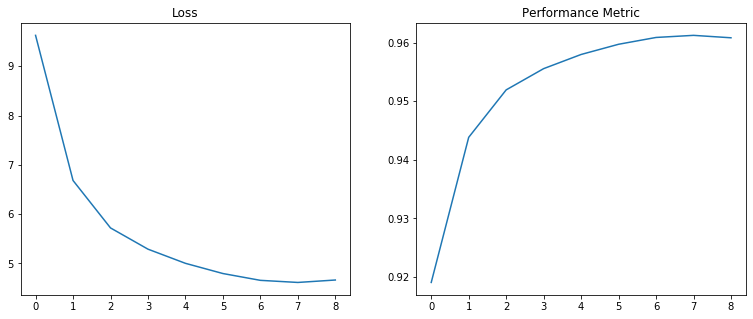

r2:  0.964
mse: 9.1


In [123]:
from sklearn.metrics import r2_score, mean_squared_error


np.random.seed(123)


hidden_layer_sizes = [20, 20]

opt = MomentumOptimizer(D=2, K=1, hidden_layer_sizes=hidden_layer_sizes, mu=.6,
                        reg=0)

model = MLPRegressor(D=2, hidden_layer_sizes=hidden_layer_sizes, K=1,
                     Z=ReLU(), optimizer=opt, learning_rate=1e-6)

model.fit(X_train, y_train, 1000)

preds = model.predict(X_test)
r2 = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
print('r2:  {:.3f}'.format(r2))
print('mse: {:.1f}'.format(mse))

# Regression - Unit Step (DummyEnv)

In [99]:
X = np.random.randn(10000, 1)
def unit_step(x):
    if x >= 0:
        return 1
    else:
        return 0
y = np.array([unit_step(x) for x in X]).reshape(-1, 1)

epoch: 0, loss: 1.15, performance_metric: -8.2227, max weight: 3.579, max weight gradient: 1607.87227077333
epoch: 50, loss: 0.11, performance_metric: 0.1555, max weight: 3.580, max weight gradient: 10.723948844988122
epoch: 100, loss: 0.14, performance_metric: -0.1002, max weight: 3.579, max weight gradient: 9.63832965203921
epoch: 150, loss: 0.14, performance_metric: -0.0966, max weight: 3.578, max weight gradient: 9.082878368196624
epoch: 200, loss: 0.14, performance_metric: -0.1030, max weight: 3.578, max weight gradient: 8.77012065249531
epoch: 250, loss: 0.14, performance_metric: -0.1014, max weight: 3.578, max weight gradient: 8.57264012570798
epoch: 300, loss: 0.14, performance_metric: -0.0990, max weight: 3.578, max weight gradient: 8.434849372268069
epoch: 350, loss: 0.14, performance_metric: -0.0958, max weight: 3.578, max weight gradient: 8.328607358447332
epoch: 400, loss: 0.14, performance_metric: -0.0894, max weight: 3.578, max weight gradient: 8.238529273624215
epoch: 4

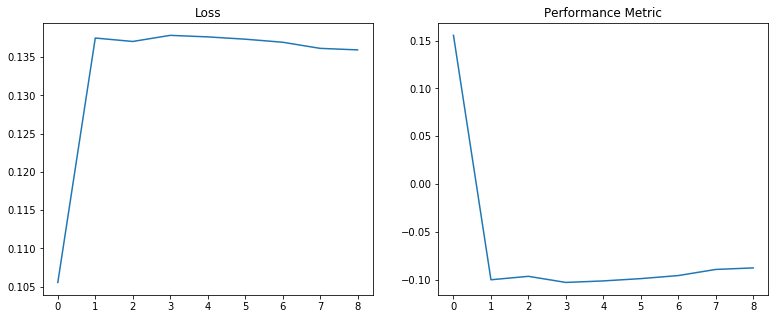

In [101]:
np.random.seed(123)


hidden_layer_sizes = [50, 50]

opt = MomentumOptimizer(D=1, K=1, hidden_layer_sizes=hidden_layer_sizes,
                       mu=.7, reg=0)

model = MLPRegressor(D=1, hidden_layer_sizes=[50, 50], K=1, Z=Sigmoid(),
                     optimizer=opt, learning_rate=1e-5)

model.fit(X, y, 500)

preds = model.predict(X)

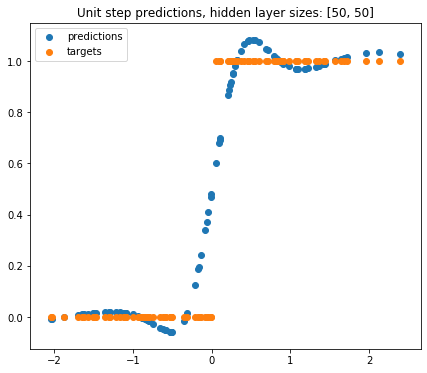

In [102]:
import matplotlib.pyplot as plt


X_test = np.random.randn(100, 1)
y_test = np.array([unit_step(x) for x in X_test]).reshape(-1, 1)
preds = model.predict(X_test)
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.scatter(X_test, preds, label='predictions')
ax.scatter(X_test, y_test, label='targets')
ax.set_title('Unit step predictions, hidden layer sizes: {}'.format(
    model.M[1:-1]))
ax.legend()